#Modern AI Pro: Getting started with LLMs
Let's build a combination of relational database and vector DB to create a modern AI application.

![](
https://drive.google.com/uc?export=view&id=1TZgFNWIV0kBIxR3owVbV8HpeoGvVEUVc)

In [ ]:
# We will use a simple utility to make the text wrap properly when printing.
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## Step 1: Get your dataset from Kaggle

Go to your account: https://www.kaggle.com/settings and create the new token button to download the kaggle.json. Extract the key and username and add it to Google Colab secrets. If you need help on this, go to our earliern [notebook](https://colab.research.google.com/drive/1mL6nG14-bViWUA-hRBj2CLSBVV7yrRT5?usp=sharing#scrollTo=xZY3nHLkl6Vj).

In [ ]:
from google.colab import userdata
from os import environ

environ["KAGGLE_KEY"]      = userdata.get('KAGGLE_KEY')
environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

! pip -q install kaggle

In [ ]:
! kaggle datasets list

In [ ]:
! kaggle datasets download -d 'saketk511/world-important-events-ancient-to-modern'
! unzip /content/world-important-events-ancient-to-modern.zip

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

df = pd.read_csv("World Important Dates.csv")
top_100_events = df['Type of Event'].value_counts().head(100)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_100_events)

# Display the generated word cloud:
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.show()

In [ ]:
!pip -q install geopandas
import geopandas as gpd
event_counts = df['Country'].value_counts()

# Load a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the event count data with the world GeoDataFrame
world = world.merge(event_counts.rename('Event Count'), left_on='name', right_index=True, how='left')

# Plotting the number of events by country
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(column='Event Count', ax=ax, legend=True, cmap='OrRd')

for idx, row in world.dropna(subset=['Event Count']).iterrows():
    if not row['geometry'].is_empty:
        plt.annotate(
            text=str(int(row['Event Count'])),
            xy=(row['geometry'].centroid.coords[0][0], row['geometry'].centroid.coords[0][1]),
            horizontalalignment='center',
            fontsize=8
        )

plt.axis('off')
plt.title('Number of Events by Country')
plt.show()

## Step 2: Getting the Relational Database

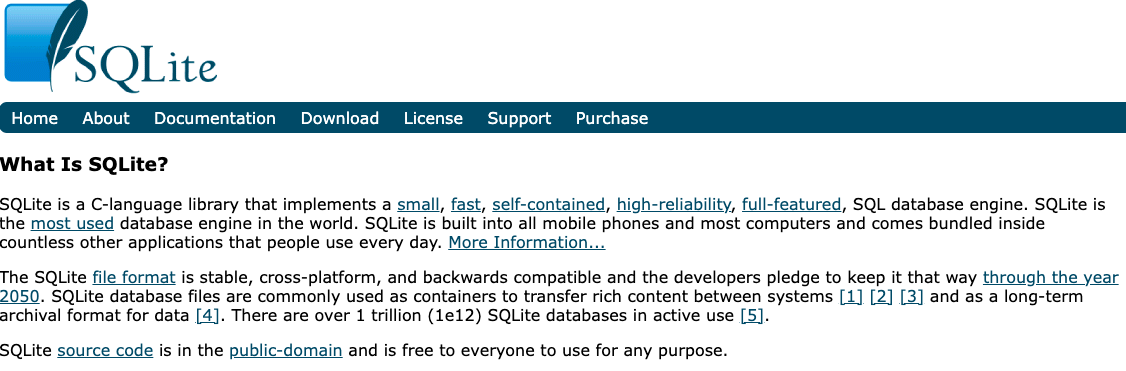

In [ ]:
%load_ext sql

In [ ]:
import sqlite3 as sql
db_path = '/content/worldevents.db'

# Connect to the SQLite database (this will create the database if it does not exist)
conn = sql.connect(db_path)

# Check if the table exists
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='world_events';")
table_exists = cursor.fetchone()

# If the table doesn't exist, create it from the DataFrame
if not table_exists:
    df.to_sql('world_events', conn, index=False)
    print("Table 'world_events' created and data inserted.")
else:
    print("Database and table 'world_events' already exist.")

In [ ]:

%%sql
sqlite:///worldevents.db
select * from world_events LIMIT 5;

## Step 3: Vectorize the Scalar DB


We are going to use a bunch of libraries:


*   Langchain
*   Chroma DB
*   sentence-transformers

A glossary will be provided which explains these libraries


In [ ]:
!pip -q install langchain langchain-community sentence-transformers chromadb
from langchain_community.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-small-en-v1.5",
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': False}
)

In [ ]:
# Query and create documents.
from langchain.docstore.document import Document
doc = []
cur = conn.cursor()
cur.execute("SELECT [Name of Incident],[Type of Event], Impact, [Place Name]  FROM world_events")
rows = cur.fetchall()


for row in rows:
    page = Document(page_content=row[0]+ ". Impact of the event:"+ row[2], metadata={' "Type of Event"': row[1], ' "Place Name"': row[3]})
    doc.append(page)

#print(doc)

In [ ]:
from langchain_community.vectorstores import Chroma
try:
  db = Chroma.from_documents(doc, embeddings)
except Exception as error:
    print("An exception occurred:", type(error).__name__)

In [ ]:
query = "Tell me interesting conflicts involving India"
docs = db.similarity_search(query)
print(docs)

In [ ]:
for doc in docs:
    # Extracting page_content and metadata for readability
    page_content = doc.page_content
    place_name = doc.metadata[' "Place Name"']
    type_of_event = doc.metadata[' "Type of Event"']

    # Formatting the output
    print(f"Event: {page_content}")
    print(f"Place: {place_name}")
    print(f"Type of Event: {type_of_event}\n")

## Step 4: Setup Mistral 7B

In [ ]:
!pip install -q -U bitsandbytes torch accelerate # related to loading custom models
!pip install -q -U langchain_core langchainhub

### Ready the quantization for better memory performance

In [ ]:
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer, pipeline
import torch

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [ ]:
model_id = "mistralai/Mistral-7B-Instruct-v0.1"
model_4bit = AutoModelForCausalLM.from_pretrained( model_id, device_map="auto",quantization_config=quantization_config)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
hf = pipeline(
    task="text-generation",
    model=model_4bit, #Quantized
    tokenizer=tokenizer,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,
    use_cache=True,
    max_length=500,
        device_map="auto",
        do_sample=True,
        top_k=5,
        num_return_sequences=1,
)
llm_mistral = HuggingFacePipeline(pipeline=hf)

In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template("Answer this question in detail: {question} from these documents {context} pulled from our database. \
Correct the names if needed. If possible, tell us how these events are connected.")
chain = (
    {"context": db.as_retriever(), "question": RunnablePassthrough()}
    | prompt
    | llm_mistral
    | StrOutputParser()
)

In [ ]:
print(chain.invoke("List all the key Conflicts involving India"))

## Step 5: Combine Mitra LLM (GPT4) with SQL

**Note:** Only one of the below methods is required to be executed - Azure or MitraLLM

In [ ]:
# If you are using Azure Open AI directly.
!pip -q install langchain_openai
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    api_key=userdata.get('OPENAI_MSFT_KEY'),
    azure_deployment=userdata.get('AZURE_DEPLOYMENT'),
    azure_endpoint=userdata.get("AZURE_OPENAI_ENDPOINT"),
    openai_api_version="2023-07-01-preview"
)

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install git+https://gitlab.com/gauthammsam/mitrallm.git --quiet
from mitrallm import MitraLLM
llm = MitraLLM(
    token     = userdata.get("MITRA_TOKEN"),
    accessapi = userdata.get("MITRA_ENDPOINT")
)
print(llm)

In [ ]:
llm.invoke("Tell me a joke about Open AI and Sam Altman to new AI students")

In [ ]:
prompt = ChatPromptTemplate.from_template("Answer this question in detail: {question} from these documents {context} pulled from our database. \
Correct the names if needed. If possible, tell us how these events are connected.")
chain_gpt = (
    {"context": db.as_retriever(), "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)
print(chain_gpt.invoke("List all the key Conflicts involving India"))

## Step 6: Writing SQL queries with GPT4 (Optional)

In [ ]:
template = """Based on the table schema below, write a SQL query that would answer the user's question:
{schema}

Question: {question}
Give ONLY the query without the prepending ```sql and no explanation around the code. This has to be passed to a code interpreter.
"""
prompt = ChatPromptTemplate.from_template(template)

In [ ]:
from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///worldevents.db")
def get_schema(_):
    return db.get_table_info()
def run_query(query):
    return db.run(query)

In [ ]:
sql_response = (
    RunnablePassthrough.assign(schema=get_schema)
    | prompt
        | llm.bind(stop=["\nSQLResult:"])
    | StrOutputParser()
)
print(sql_response.invoke({"question": "How many events are there?"}))

In [ ]:
sql_chain = (
    RunnablePassthrough.assign(query=sql_response).assign(
        schema=get_schema,
        response=lambda x: db.run(x["query"]),
    )
)
sql_chain.invoke({"question": "How many rows are there?"})

In [ ]:
print(sql_chain.invoke({"question":"Give me the name and year of battles (use synonyms such as military and military battle) that happened in India"}))